In [2]:
from datasets import Dataset, DatasetDict
from pycocotools.coco import COCO
from PIL import Image, ImageDraw, ImageFont
from functools import partial

import numpy as np

In [3]:
MODEL_NAME = "facebook/detr-resnet-50"
IMAGE_SIZE = 480

coco_root_fp = "../data/coco/project-1-at-2024-09-15-01-58-839140c6/"
coco_dataset = COCO(coco_root_fp + "result.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
def get_image_info(image_id):
    # Load image from file path
    img_info = coco_dataset.loadImgs(image_id)[0]
    img_path = coco_root_fp + img_info["file_name"]
    img = Image.open(img_path)

    # Load annotations from image id
    annotation_ids = coco_dataset.getAnnIds(imgIds=image_id)
    annotations = coco_dataset.loadAnns(annotation_ids)

    # Extract object details from annotations
    objects_id = [a["id"] for a in annotations]
    objects_area = [a["area"] for a in annotations]
    objects_bbox = [a["bbox"] for a in annotations]
    objects_category_id = [a["category_id"] for a in annotations]

    return {
        "image_id": img_info["id"],
        "image": img,
        "width": img_info["width"],
        "height": img_info["height"],
        "objects": {
            "id": objects_id,
            "area": objects_area,
            "bbox": objects_bbox,
            "category_id": objects_category_id,
        }
    }

def split_dataset(dataset, train_split=0.7, valid_split=0.15, test_split=0.15):
    assert train_split + valid_split + test_split == 1, "Splits must add up to 1"
    
    # Calculate the number of samples for each split
    total_size = len(dataset)
    train_size = int(total_size * train_split)
    valid_size = int(total_size * valid_split)

    # Split the dataset
    train_dataset = dataset.select(range(train_size))
    valid_dataset = dataset.select(range(train_size, train_size + valid_size))
    test_dataset = dataset.select(range(train_size + valid_size, total_size))
    
    return DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset,
        'test': test_dataset
    })


# Get image information for each image ID
image_ids = coco_dataset.getImgIds()
coco_images = [get_image_info(id) for id in image_ids]

# Convert the list of images information into a Dataset
dataset = split_dataset(Dataset.from_list(coco_images))

dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2
    })
})

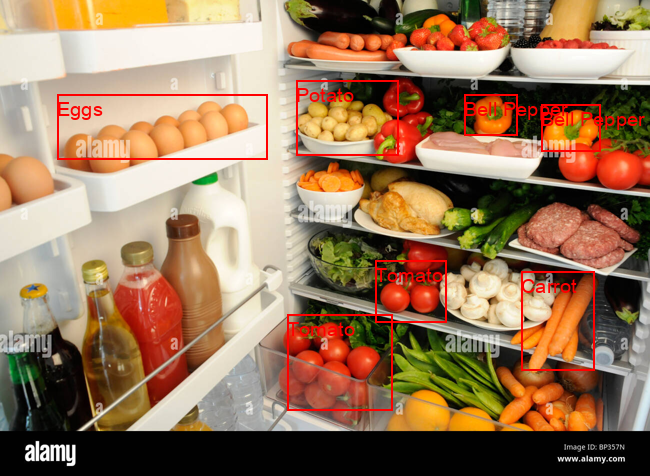

In [5]:
def visualize_annotations(dataset, idx, aspect_ratio=2):
    # Get annotations for the specified index
    annotation_ids = coco_dataset.getAnnIds(imgIds=idx)
    annotations = coco_dataset.loadAnns(annotation_ids)
    
    # Get category names
    categories = coco_dataset.loadCats(coco_dataset.getCatIds())
    category_names = {cat['id']: cat['name'] for cat in categories}

    # Load and resize the image
    image = dataset[idx]["image"]
    image = image.resize((image.width // aspect_ratio, image.height // aspect_ratio))

    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("Arial Unicode.ttf", size=20)
    except OSError:
        font = ImageFont.load_default()

    # Draw annotations on the image
    for ann in annotations:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_name = category_names[category_id]
        
        # Draw bounding box
        x, y, w, h = [dim // aspect_ratio for dim in bbox]  # Adjust bounding box coordinates
        draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
     
        # Draw category name with larger font
        draw.text((x, y), category_name, fill="red", font=font)
    
    return image

visualize_annotations(dataset["train"], 3)

In [6]:
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

In [7]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [ ]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }
